# To determine what features will best predict cpu/event

we'll calculate averages of cpu/event per CPU and processing type and use that dummy predictor
we'll fit separately fastBmk, bogomips, hs06, whetstone to cpu/event for each processing type adn use that as a predictor

compare all 5.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


### Get datasets

In [2]:
jobs = pd.read_csv('job.csv').set_index('pandaid')
#jobs = jobs[jobs['nevents']>20]

del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']

jobs.head()

,hs06,processingtype,cpuPerEvent,inputsize
pandaid,,,,
3352703758,107,recon,4.436667,12659125
3354732793,10,evgen,1.100000,88453
3326375042,96,reprocessing,12.623182,2620990676
3327803396,77,merge,0.358200,22832203370
3330689156,90,merge,0.337855,7124546461


In [3]:
benchmarks = pd.read_csv('benchmark.csv').set_index('pandaid')

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

print(benchmarks.columns)

benchmarks.head()

Index(['bogomips', 'ip', 'site', 'mpnum', 'cpuname', 'meminfo', 'fastBmk',
       'whetstone'],
      dtype='object')
Index(['bogomips', 'mpnum', 'cpuname', 'fastBmk', 'whetstone'], dtype='object')


,bogomips,mpnum,cpuname,fastBmk,whetstone
pandaid,,,,,
3322806223,5333.52,1,QEMU Virtual CPU version (cpu64-rhel6),9.223674,3195.99
3357390345,4988.44,8,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,12.610536,3101.83
3322633663,5000.00,1,Intel(R) Xeon(R) CPU E5420 @ 2.50GHz,12.129380,2749.34
3357339988,4988.44,8,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,17.159994,3377.43
3322488785,4988.06,1,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,23.731048,3599.70


### join dataframes and filter out bad rows

In [4]:
benchmarks = benchmarks.join(jobs,how='inner')
benchmarks = benchmarks[benchmarks.cpuPerEvent > 0]
benchmarks = benchmarks[benchmarks.mpnum == 1]

del benchmarks['mpnum']

benchmarks.head()

,bogomips,cpuname,fastBmk,whetstone,hs06,processingtype,cpuPerEvent,inputsize
pandaid,,,,,,,,
3323737831,5199.28,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.863749,3612.79,10,simul,73.644,192403214
3323782011,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.869888,3628.96,10,evgen,154.110,78433220
3323782017,4189.98,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,18.136020,3306.22,10,evgen,159.280,78433220
3323788151,5199.24,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz,20.642202,3495.29,10,evgen,167.210,78433220
3323820043,4787.82,Intel(R) Xeon(R) CPU E5620 @ 2.40GHz,6.792453,1532.55,13,evgen,426.825,78426201


### split over different processing types 

In [5]:
UniqueProcessingTypes = benchmarks.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

# UniqueProcessingTypes.remove('overlay')
# UniqueProcessingTypes.remove('deriv')

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}

#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = benchmarks[:][benchmarks.processingtype == key]
    

['simul' 'evgen' 'reprocessing' 'merge' 'recon' 'pmerge' 'pile']


### plot correlations

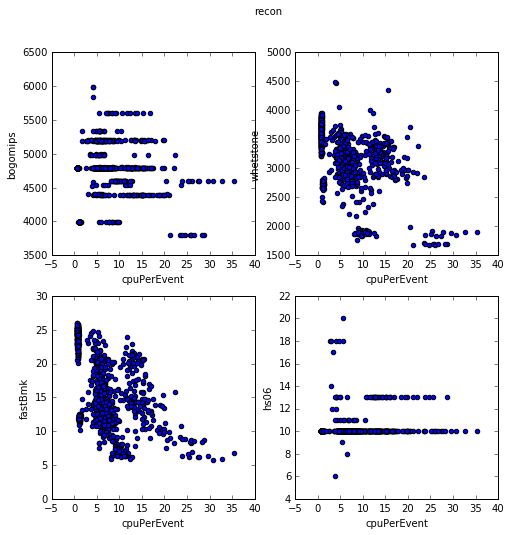

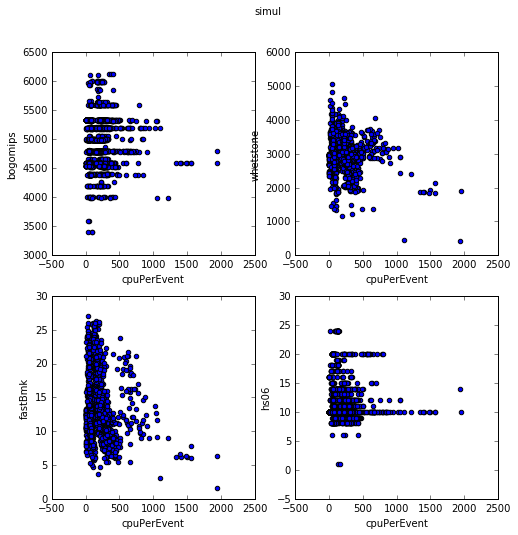

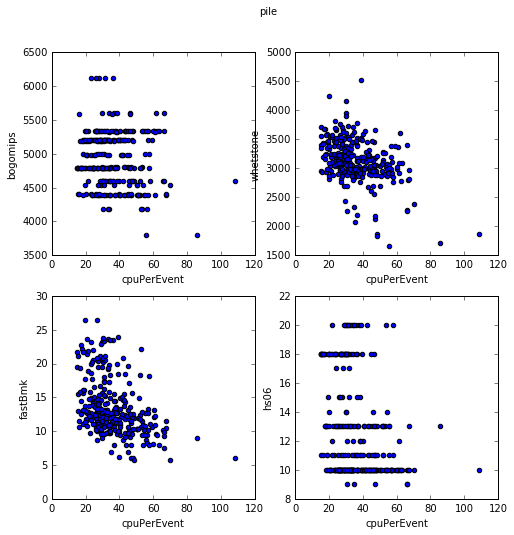

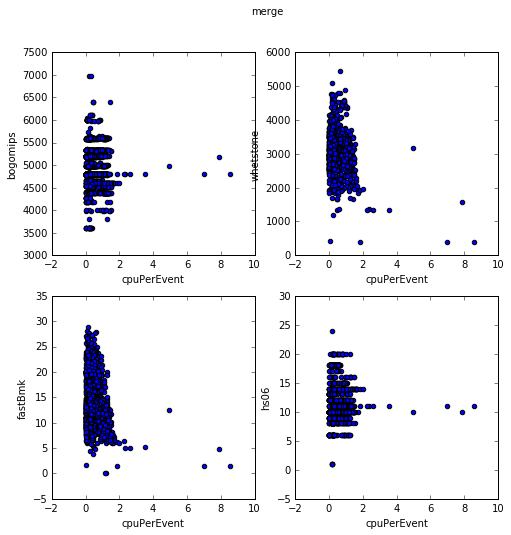

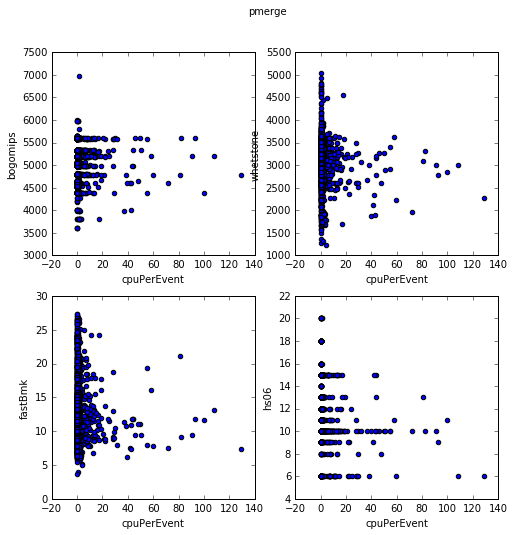

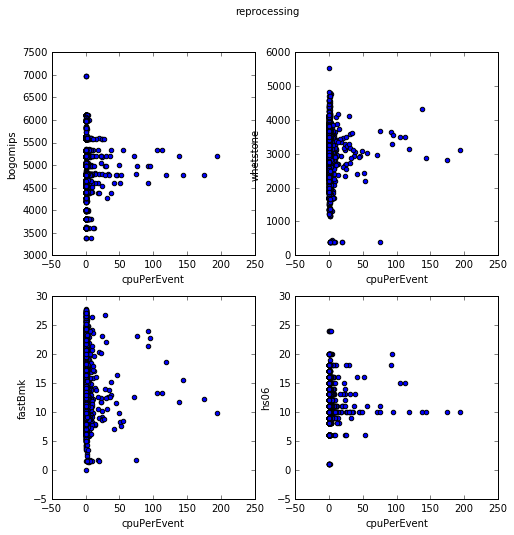

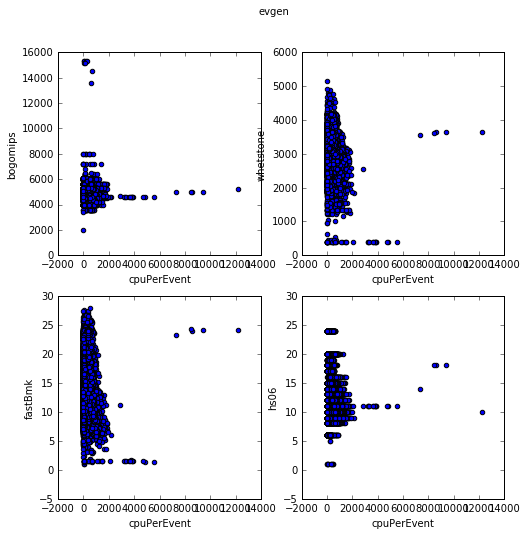

In [6]:
feat = ['bogomips', 'fastBmk', 'whetstone', 'hs06']
for pt in ProcessingType.keys():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.suptitle(pt)
    data = ProcessingType[pt]
    for nf, f in enumerate(feat):
        i = nf%2
        j = int(nf/2)
        data.plot(ax=axes[i,j], x="cpuPerEvent", y=f, kind='scatter',figsize=(8, 8)) 

### split on training and testing samples

===========  recon =============
(706, 6) (706, 1) (177, 6) (177, 1)
***  bogomips  ***
cross validation score:  -144.262801564
	evs: -0.0002 	mae:     4.0077 	mse:    30.8477 	r2:   -0.0002
***  fastBmk  ***
cross validation score:  -63.2305851813
	evs: 0.2152 	mae:     3.6451 	mse:    24.2872 	r2:    0.2125
***  whetstone  ***
cross validation score:  -87.9836559525
	evs: 0.1298 	mae:     3.8701 	mse:    26.8429 	r2:    0.1296
***  hs06  ***
cross validation score:  -125.394124134
	evs: 0.0273 	mae:     3.9295 	mse:    30.0033 	r2:    0.0272
Describe predictions
            actual    bogomips     fastBmk        hs06   whetstone
count  177.000000  177.000000  177.000000  177.000000  177.000000
mean     6.637289    6.659179    6.924669    6.565075    6.720038
std      5.569198    0.268896    3.232309    0.674153    2.746609
min      0.632000    5.983996    1.391262    5.613439   -1.400787
25%      1.131004    6.618401    3.878592    6.443190    4.821423
50%      6.084388    6.618401   

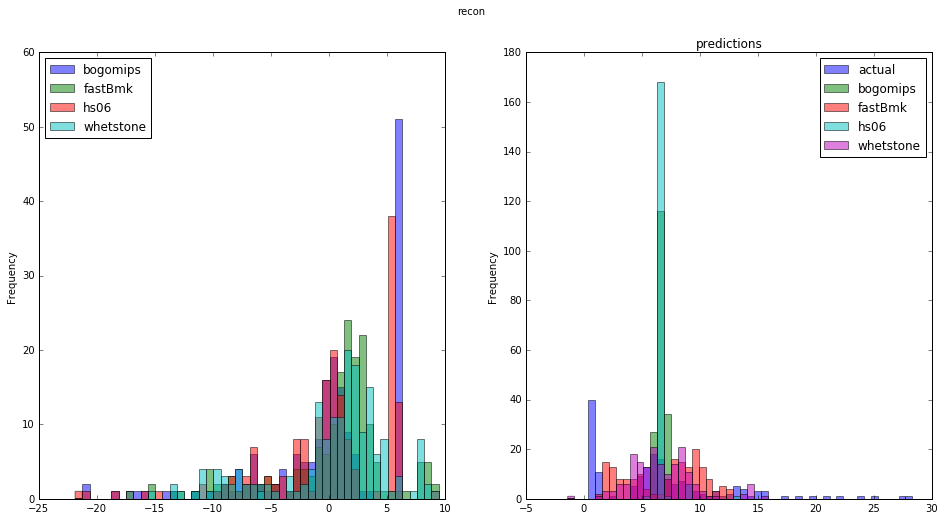

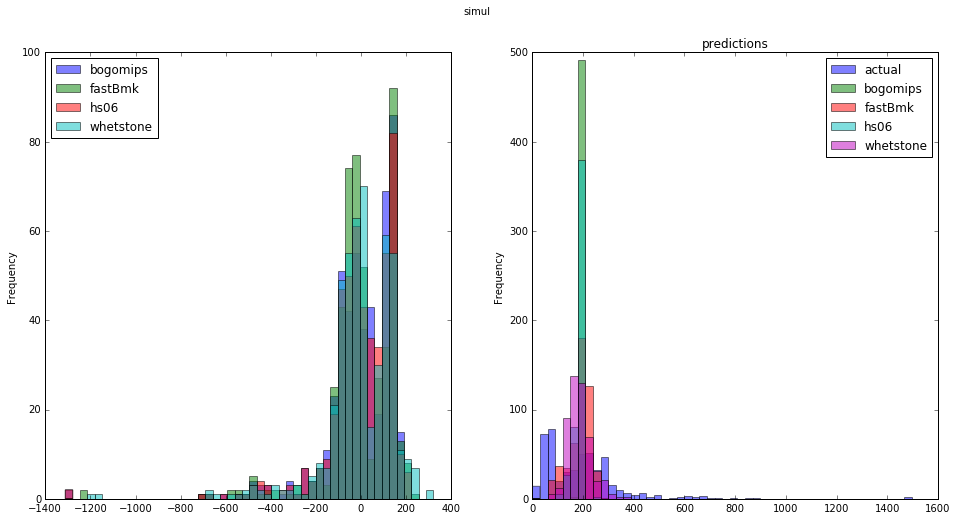

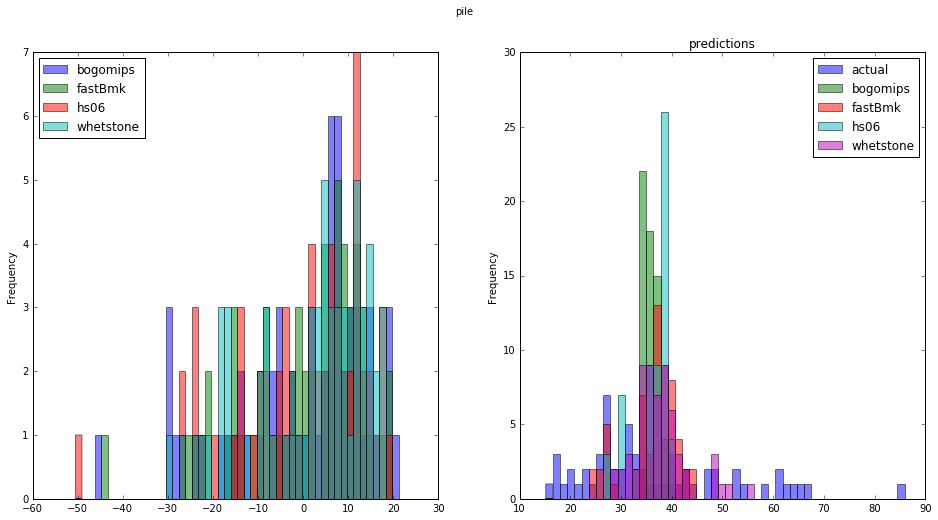

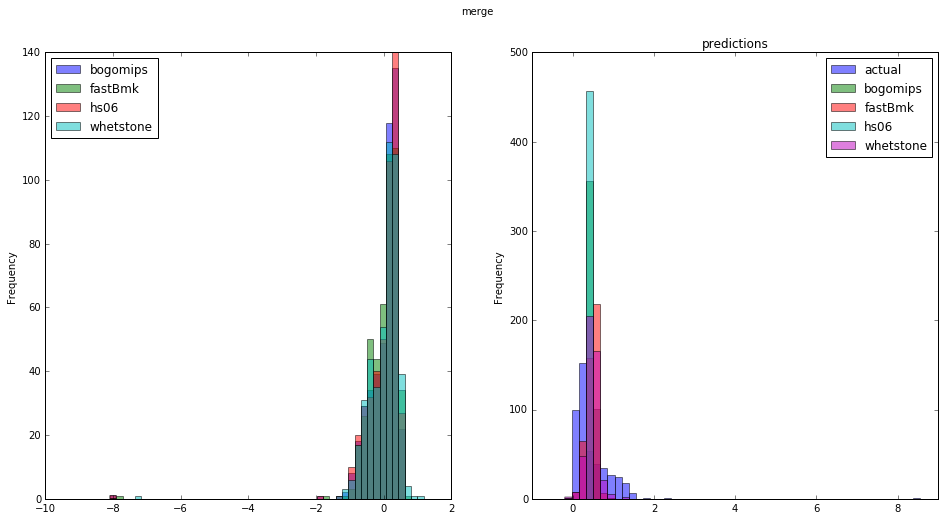

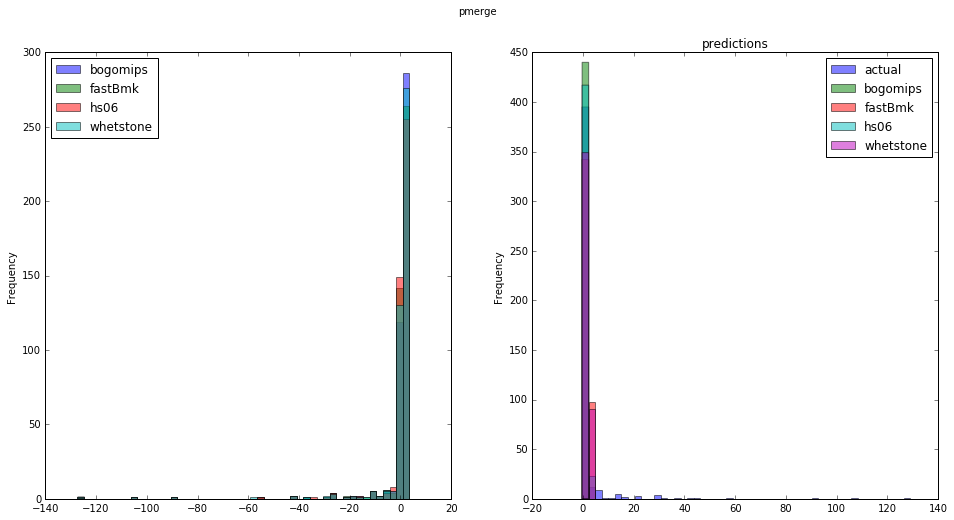

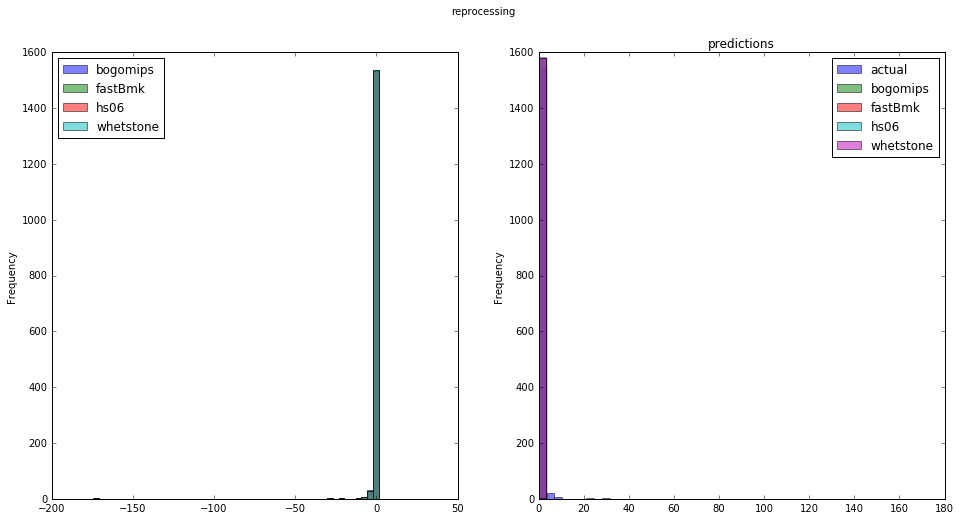

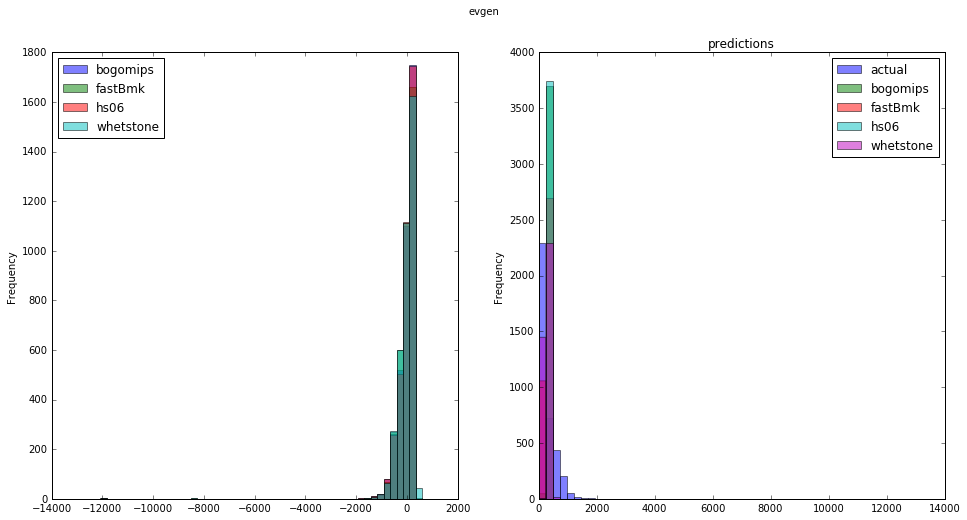

In [7]:
R_mse = {}
R_r2  = {}

#####  LRs ####
lr = LinearRegression()

for pt in ProcessingType:
    print("=========== ",pt,"=============")
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    #target
    y = data['cpuPerEvent'].copy()
    y = y.values.reshape(-1, 1)
    #print(data['cpuPerEvent'].describe())
    
    X=data.copy()
    del X['cpuPerEvent']
    del X['processingtype']
    #print(X.columns)

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=41)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    predictions={'actual':y_test.flatten()}
    errors = {}
    
    for f in feat:
        print( "*** ",f," ***")
        
        lm = lr.fit(X_train[f].values.reshape(-1,1), y_train)
        #print ("Linear model:",lm.coef_ , lm.intercept_)
        #hold-out testing
        y_test_predict = lm.predict(X_test[f].values.reshape(-1,1))
        
        # to do cross validation 
        scores = cross_val_score(lr, X[f].values.reshape(-1,1), y, cv=10, scoring='r2')
        print("cross validation score: ", scores.mean())
        #y_test_predict = cross_val_predict(lr, X, y, cv=10)
        
        
        errors[f] = (y_test_predict-y_test).flatten().tolist()
        predictions[f] = y_test_predict.flatten().tolist()
        
        evs = explained_variance_score(y_test, y_test_predict)
        mae = mean_absolute_error(y_test, y_test_predict)
        mse = mean_squared_error(y_test, y_test_predict)
        r2 = r2_score(y_test, y_test_predict) 
        print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
        tmse.append(mae)
        tr2.append(r2)
        #print("---------------------------------------")
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.suptitle(pt)
    plt.title("errors")
    pl = pd.DataFrame(errors)
    #print("Describe residuals\n", pl.describe())
    pl.plot(ax=axes[0], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    
    pl = pd.DataFrame(predictions)
    plt.title("predictions")
    print("Describe predictions\n", pl.describe())
    pl.plot(ax=axes[1], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
        
    ###  based on CPU
    cdata = data.copy()
    del cdata['processingtype']
    del cdata['bogomips']
    del cdata['fastBmk']
    del cdata['whetstone']
    del cdata['hs06']

    cdata_train, cdata_test =  train_test_split( cdata, test_size=0.20, random_state=41)
    print(cdata_train.shape, cdata_test.shape)

    predictions_on_CPU = cdata_train.groupby('cpuname').mean()
    #print(predictions_on_CPU)

    res=[]
    pre=[]
    not_used=0
    for index, row in cdata_test.iterrows():
        cn  = row['cpuname']
        cpe = row['cpuPerEvent']
        if cn in predictions_on_CPU.index:
            res.append(cpe)
            pre.append(predictions_on_CPU.loc[cn,'cpuPerEvent'])
        else:
            not_used += 1 

    #print(not_used,' test results had CPU not seen in training data.')
        
    #for i in range(len(res)):
    #    print(res[i], pre[i])
    comp=pd.DataFrame({'res':res,'pre':pre})
    #comp

    evs = explained_variance_score(comp.res, comp.pre)
    mae = mean_absolute_error(comp.res, comp.pre)
    mse = mean_squared_error(comp.res, comp.pre)
    r2 = r2_score(comp.res, comp.pre) 
    #print( "%2.4f" % evs, "{:>10.4f}".format(mae), "{:>10.4f}".format(mse), "{:>10.4f}".format(r2)) 
    tmse.append(mae)
    tr2.append(r2)
    R_mse[pt]=tmse
    R_r2[pt]=tr2
    print("---------------------------------------")
        
#print(R_r2)

### plot results

In [8]:
Results=pd.DataFrame(R_r2,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,0.000030,-0.000554,0.022642,-0.004512,-0.000226,-0.000155,-0.000812
fastBmk,0.000372,0.089259,0.212659,0.001943,0.212495,-0.001224,0.027506
whetstone,0.005166,0.085529,0.255753,0.000526,0.129627,-0.000852,0.028544
hs06,0.001057,-0.000317,0.083925,0.007375,0.027152,-0.000870,0.013122
cpu name,0.016243,0.140447,0.217019,-0.002090,0.463891,-0.005119,0.120251


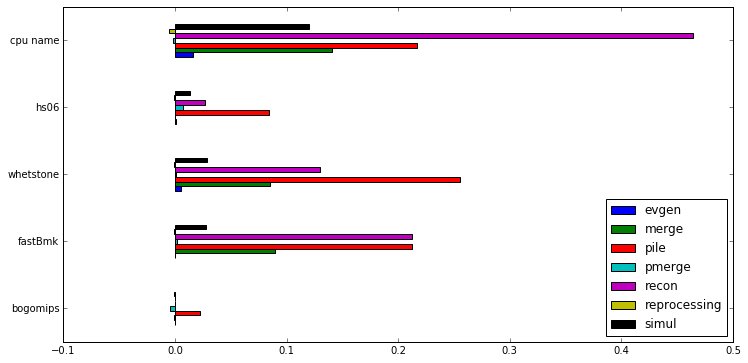

In [9]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks.png")

In [10]:
Results=pd.DataFrame(R_mse,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,228.091372,0.340309,11.863886,3.131994,4.007715,1.085477,109.177850
fastBmk,225.938282,0.327433,10.727067,3.148702,3.645133,1.076175,104.307031
whetstone,226.822074,0.342512,11.023535,3.140552,3.870116,1.073479,104.725674
hs06,227.629569,0.339331,11.589452,3.147288,3.929514,1.084599,106.492670
cpu name,220.909278,0.278620,10.868744,3.211059,3.035792,1.109132,95.265571


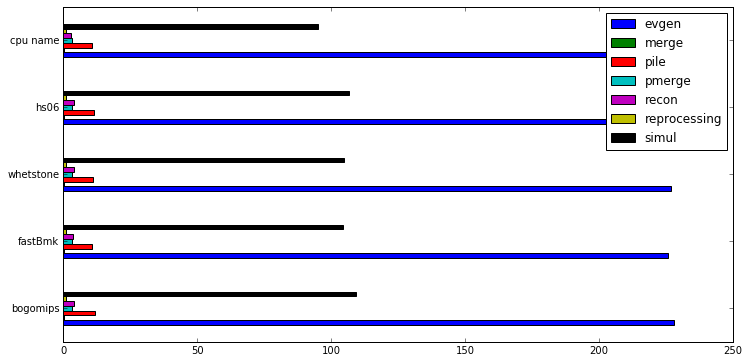

In [11]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks.png")